## Prathmesh Urkude
## A3_51

### RANSAC (RANdom SAmple Consensus)

In [59]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [60]:
img1 = cv2.imread('power_plant_1.jpg')
img2 = cv2.imread('power_plant_2.jpg')

In [61]:
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

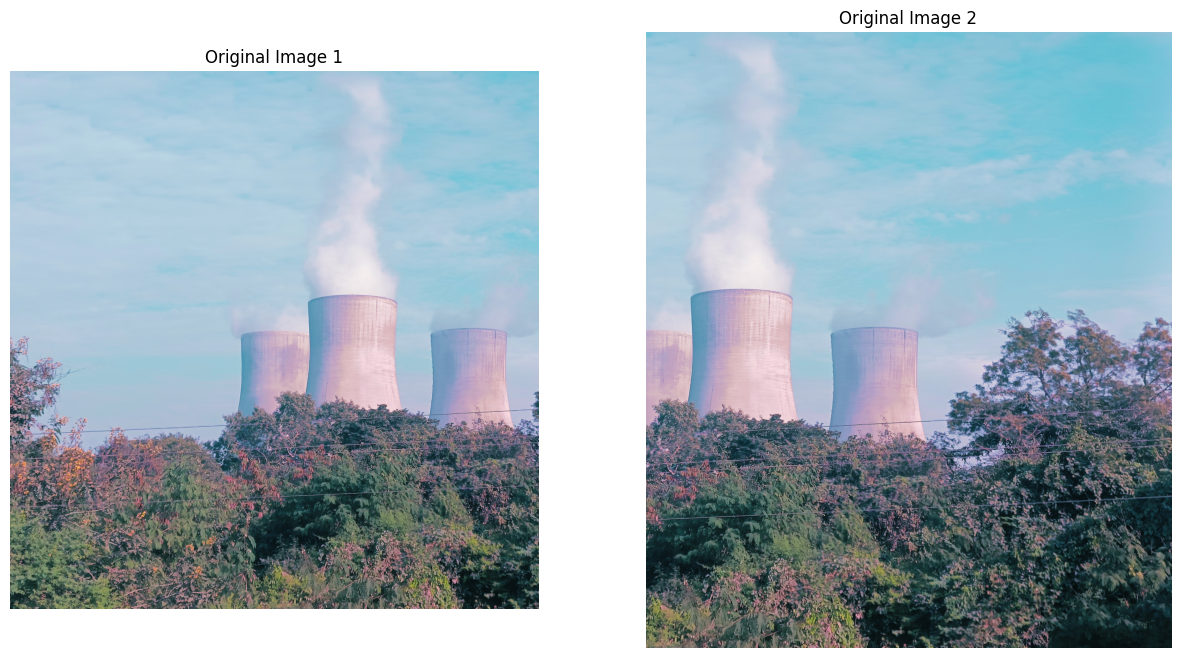

In [62]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.title('Original Image 1')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.title('Original Image 2')
plt.axis("off")

plt.show()

In [63]:
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

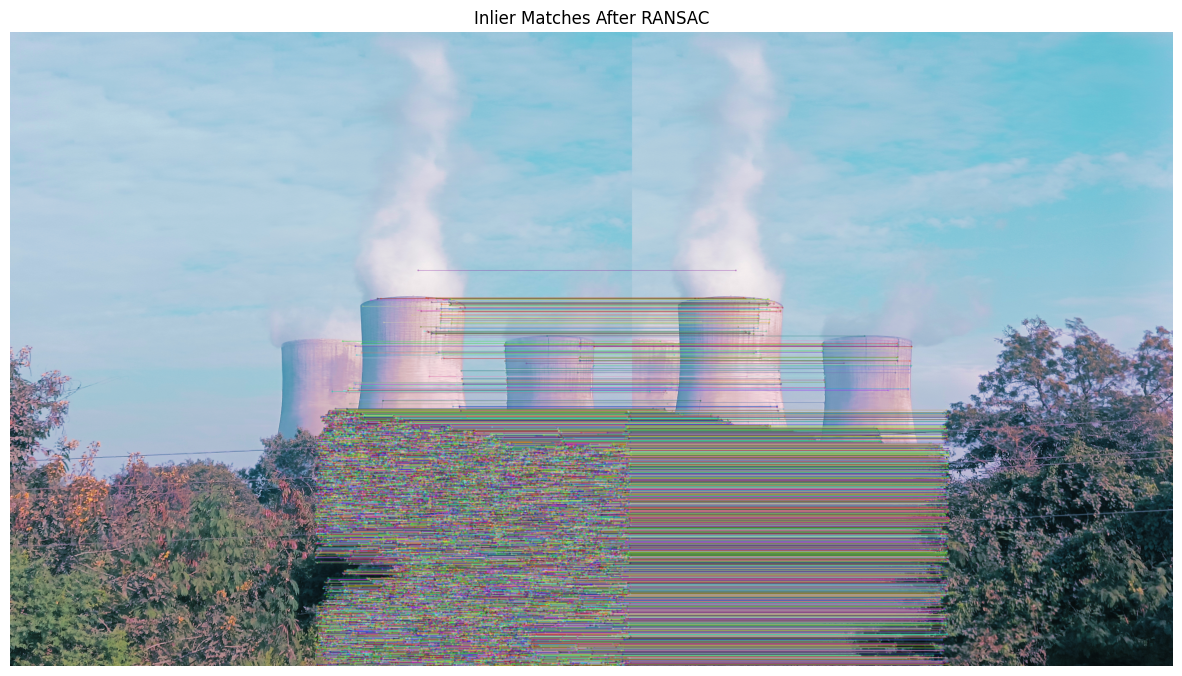

In [64]:
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
matches_mask = mask.ravel().tolist()

img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, matchesMask=matches_mask, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(15, 10))
plt.imshow(img_matches)
plt.title("Inlier Matches After RANSAC")
plt.axis('off')
plt.show()

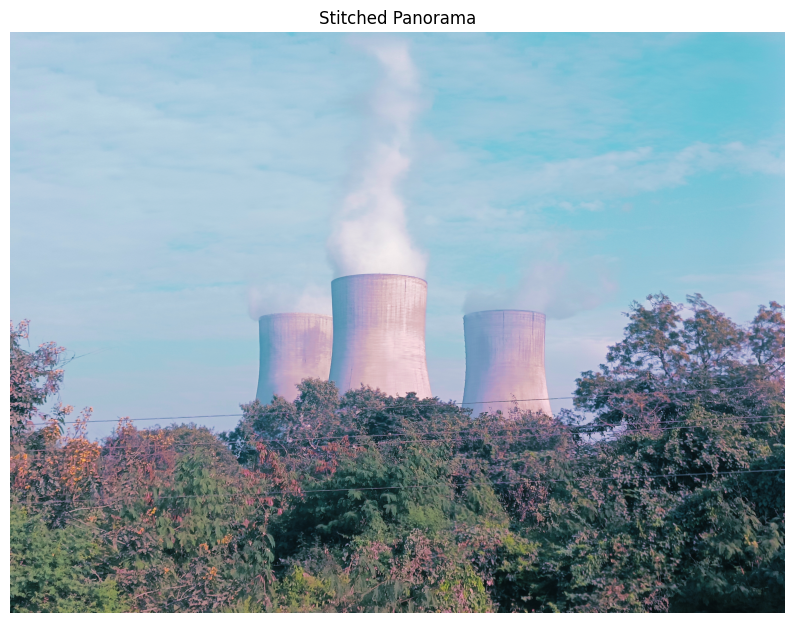

In [65]:
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

height1, width1 = img1.shape[:2]
height2, width2 = img2.shape[:2]

corners_img1 = np.float32([[0, 0], [0, height1], [width1, height1], [width1, 0]]).reshape(-1, 1, 2)
transformed_corners = cv2.perspectiveTransform(corners_img1, H)

all_corners = np.concatenate((transformed_corners, np.float32([[0, 0], [0, height2], [width2, height2], [width2, 0]]).reshape(-1, 1, 2)), axis=0)
[x_min, y_min] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
[x_max, y_max] = np.int32(all_corners.max(axis=0).ravel() + 0.5)
translation_dist = [-x_min, -y_min]

H_translate = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

stitched_img = cv2.warpPerspective(img1, H_translate @ H, (x_max - x_min, y_max - y_min))
stitched_img[translation_dist[1]:height2 + translation_dist[1], translation_dist[0]:width2 + translation_dist[0]] = img2

plt.figure(figsize=(10, 10))
plt.imshow(stitched_img)
plt.title("Stitched Panorama")
plt.axis('off')
plt.show()